In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
import os
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from PIL import Image
from os.path import splitext

In [30]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
path="/content/drive/MyDrive/cityscapes_data"
def images_upload(path):
    images=[]
    for root,subfolders,files in os.walk(path):
        for file in tqdm(files):
            filename=root+os.sep+file
            if filename.endswith('jpg') or filename.endwith('png'):
                images.append(filename)
    return images
images=images_upload(path)


0it [00:00, ?it/s]
100%|██████████| 1330/1330 [00:00<00:00, 681043.14it/s]


In [31]:
def convert_image_rgb(data):
    imgs=[]
    for i in tqdm(data):
        img = cv2.imread(i,cv2.COLOR_BGR2RGB)
        del i
        imgs.append(img)
    return imgs
img=convert_image_rgb(images)

100%|██████████| 1830/1830 [00:17<00:00, 106.43it/s]


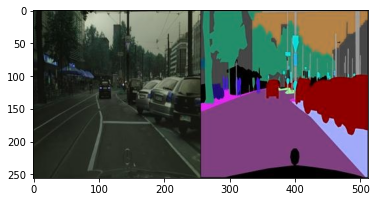

In [32]:
plt.imshow(img[np.random.randint(0,len(img))]);

In [34]:
def split_input_mask(data):
    inputs=[]
    mask=[]
    for i in data:
        a=i[:,:256]
        inputs.append(a)
        b=i[:,256:]
        mask.append(b)
    return inputs,mask
inputs,mask=split_input_mask(img)

In [35]:
del images
del img

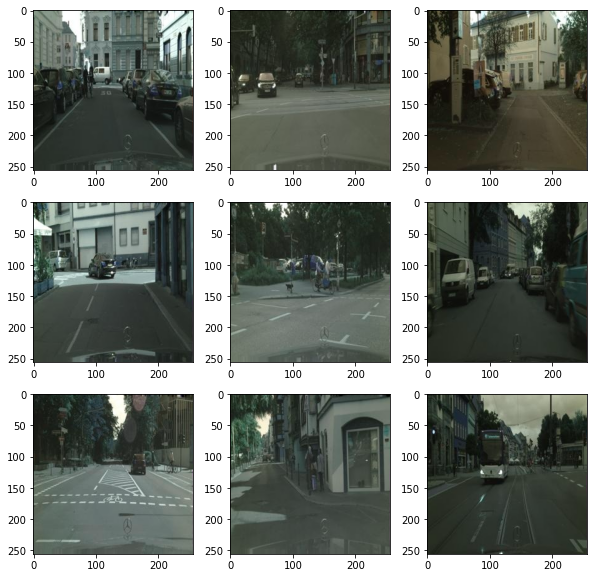

In [36]:
def show_images(data):
    plt.figure(figsize=(10,10))
    for i in range(9):
        idx=np.random.randint(0,len(data))
        plt.subplot(3,3,i+1)
        img=data[idx]
        plt.imshow(img)
show_images(inputs)

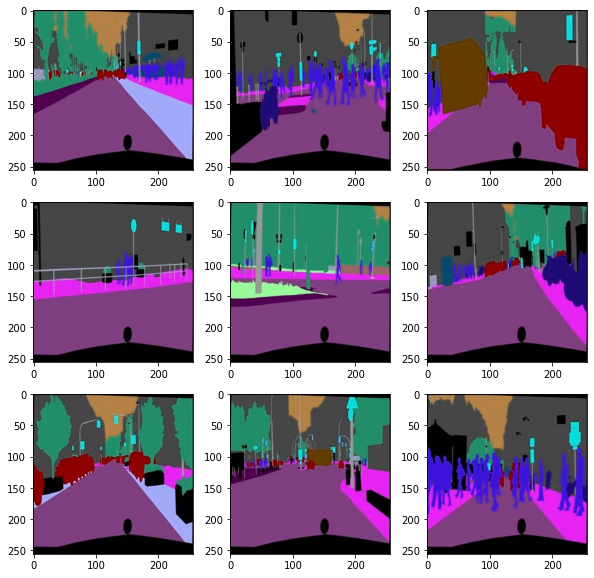

In [37]:
show_images(mask)

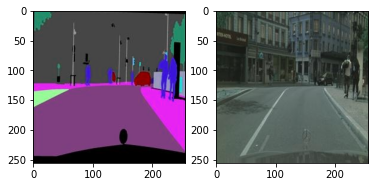

In [38]:
def images_compare(inputs,mask):
    idx_new=np.random.randint(0,len(mask))
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(mask[idx_new])
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(inputs[idx_new],cmap='gray')
    plt.show()
images_compare(inputs,mask)

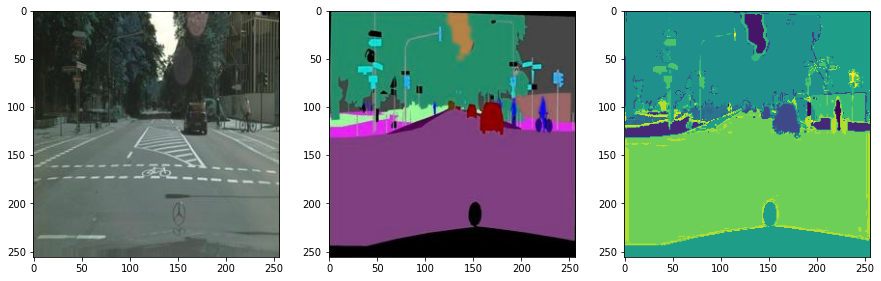

In [39]:
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1,3)
num_classes = 20
label_model = KMeans(n_clusters = num_classes)
label_model.fit(color_array)
label_class = label_model.predict(mask[10].reshape(-1,3)).reshape(256,256)
fig, axes = plt.subplots(1,3,figsize=(15,5))
axes[0].imshow(inputs[10]);
axes[1].imshow(mask[10]);
axes[2].imshow(label_class);

In [40]:
def new_labels(mask):
    num_items = 1000
    color_array = np.random.choice(range(256), 3*num_items).reshape(-1,3)
    num_classes = 10
    label_model = KMeans(n_clusters = num_classes)
    label_model.fit(color_array)
    labels=[]
    for i in tqdm(range(len(mask))):
        label_class = label_model.predict(mask[i].reshape(-1,3)).reshape(256,256)
        labels.append(label_class)
    return labels

In [41]:
labels=new_labels(mask)
idx=np.random.randint(0,len(labels))
classes,freq=np.unique(labels[idx],return_counts=True)
print(f'number of classes :{len(classes)}')

100%|██████████| 1830/1830 [00:08<00:00, 224.34it/s]

number of classes :10


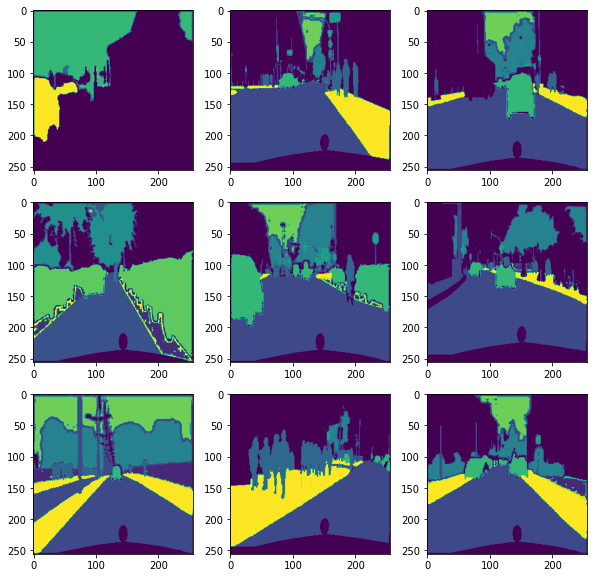

In [42]:
plt.figure(figsize=(10,10))
for i in range(9):
        plt.subplot(3,3,i+1)
        im=labels[i]
        plt.imshow(im)
# plt.imshow(a)

In [43]:
def rescale(data):
    rescaled=[]
    for i in tqdm(data):
        img=tf.image.convert_image_dtype(i, tf.float32)
        del i
        rescaled.append(img)
    return rescaled

In [44]:
rescaled_input=rescale(inputs)

100%|██████████| 1830/1830 [00:01<00:00, 1513.65it/s]


In [45]:
def build_model(inputsize=(256,256,3),classes=None):
    inputs = tf.keras.Input(shape=(inputsize))

    conv = tfl.Conv2D(32, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv1')(
        inputs)
    x=tfl.BatchNormalization()(conv)
    x=tfl.LeakyReLU()(x)
    x1 = tfl.Conv2D(32, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv2')(
        x)
    x=tfl.BatchNormalization()(x1)
    x=tfl.LeakyReLU()(x)
    x = tfl.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='MaxPool1')(x)

    x = tfl.Conv2D(64, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv3')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x2 = tfl.Conv2D(64, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv4')(x)
    x=tfl.BatchNormalization()(x2)
    x=tfl.LeakyReLU()(x)
    x = tfl.MaxPool2D(pool_size=(2, 2), name='MaxPool2')(x)

    x = tfl.Conv2D(128, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv5')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x3 = tfl.Conv2D(128, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv6')(x)
    x=tfl.BatchNormalization()(x3)
    x=tfl.LeakyReLU()(x)
    x = tfl.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='MaxPool3')(x)

    
    x = tfl.Conv2D(256, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv7')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(256, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv8')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    
    x = tfl.Conv2DTranspose(128, (3, 3), strides=2, padding="same")(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)

    x = tfl.concatenate([x, x3], axis=3)
    
    x = tfl.Conv2D(128, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv9')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(128, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv10')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2DTranspose(64, (3, 3), strides=2, padding="same")(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)

    x = tfl.concatenate([x, x2], axis=3)

    x = tfl.Conv2D(64, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv11')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(64, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv12')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    
    x = tfl.Conv2DTranspose(32, (3, 3), strides=2, padding="same")(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)

    x = tfl.concatenate([x, x1], axis=3)

    x = tfl.Conv2D(32, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv25')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(32, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv26')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    
    outputs = tfl.Conv2D(classes, (1, 1), padding="same", activation='softmax', name='Outputs')(x)
    final_model = tf.keras.Model(inputs=inputs, outputs=outputs)
    final_model.summary()
    return final_model

In [46]:
mymodel=build_model(classes=10)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 256, 256, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_17 (BatchN  (None, 256, 256, 32  128        ['Conv1[0][0]']                  
 ormalization)                  )                                                           

In [ ]:
img_file = './model_arch.png'

tf.keras.utils.plot_model(mymodel, to_file=img_file, show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [47]:
del inputs

In [48]:
def split_data(x,y,test_size=0.2):
    x1=np.array(x)
    del x
    y1=np.array(y)
    del y
    x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size=test_size)
    return  x_train, x_test, y_train, y_test

In [49]:
 x_train, x_test, y_train, y_test=split_data(rescaled_input[:1300],labels[:1300],test_size=0.2)

In [50]:
def callbacks(patience=5):
    checkpoint = tf.keras.callbacks.ModelCheckpoint('seg_model.h5', monitor='loss', verbose=1, save_best_only=True, save_weights_only=True)
    early=tf.keras.callbacks.EarlyStopping(monitor='loss',patience=patience)
    callbacks_list=[checkpoint, early]
    return callbacks_list

In [51]:
mymodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss=tf.keras.losses.sparse_categorical_crossentropy,metrics=['acc'])
hist=mymodel.fit(x_train,y_train,batch_size=16,epochs=200,callbacks=callbacks())

Epoch 1/200
65/65 [==============================] - ETA: 0s - loss: 1.1677 - acc: 0.6240
Epoch 00001: loss improved from inf to 1.16775, saving model to seg_model.h5
65/65 [==============================] - 46s 674ms/step - loss: 1.1677 - acc: 0.6240
Epoch 2/200
65/65 [==============================] - ETA: 0s - loss: 0.9437 - acc: 0.6896
Epoch 00002: loss improved from 1.16775 to 0.94367, saving model to seg_model.h5
65/65 [==============================] - 44s 672ms/step - loss: 0.9437 - acc: 0.6896
Epoch 3/200
65/65 [==============================] - ETA: 0s - loss: 0.8458 - acc: 0.7169
Epoch 00003: loss improved from 0.94367 to 0.84578, saving model to seg_model.h5
65/65 [==============================] - 44s 673ms/step - loss: 0.8458 - acc: 0.7169
Epoch 4/200
65/65 [==============================] - ETA: 0s - loss: 0.7845 - acc: 0.7372
Epoch 00004: loss improved from 0.84578 to 0.78446, saving model to seg_model.h5
65/65 [==============================] - 44s 674ms/step - loss: 0

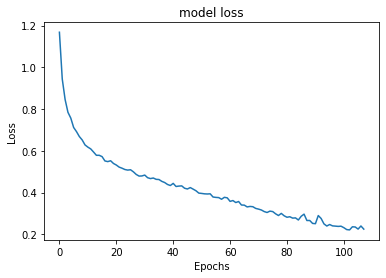

In [52]:
plt.plot(hist.history['loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

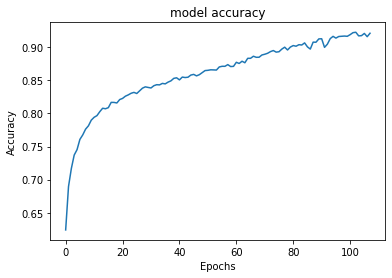

In [53]:
plt.plot(hist.history["acc"])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

In [54]:
pred=mymodel.predict(x_test)
y_pred=tf.argmax(pred,axis=-1)

In [55]:
def show_predications(x_test,y_test,y_pred):
    idx=np.random.randint(0,len(y_pred))
    fig, axes = plt.subplots(1,3,figsize=(10,10))
    axes[0].imshow(x_test[idx])
    axes[0].set_title("original")
    axes[1].imshow(y_test[idx])
    axes[1].set_title("mask")
    axes[2].imshow(y_pred[idx])
    axes[2].set_title("predicated")

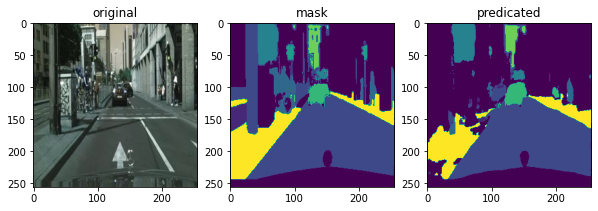

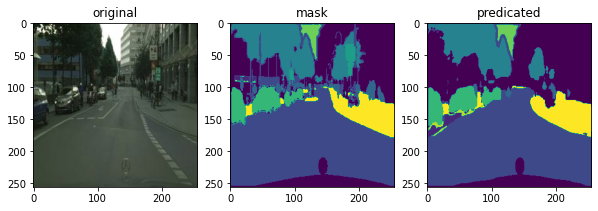

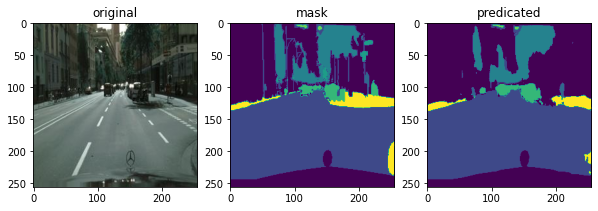

In [56]:
for i in range(3):
    show_predications(x_test,y_test,y_pred)

In [58]:
import pandas as pd

df = pd.DataFrame(hist.history)
df

,loss,acc
0,1.167745,0.624000
1,0.943668,0.689557
2,0.845775,0.716860
3,0.784463,0.737166
4,0.756650,0.745333
...,...,...
103,0.236433,0.917284
104,0.235418,0.917608
105,0.225444,0.920963
106,0.240224,0.916070


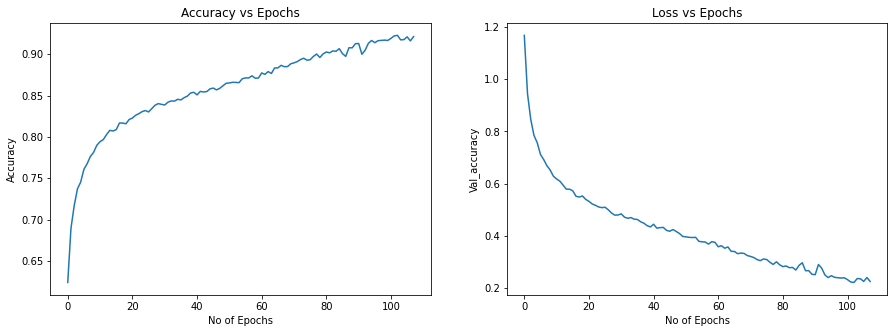

In [64]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2, figsize=(15, 5))


axes[0].plot(df.acc)
axes[0].set_xlabel('No of Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy vs Epochs')

axes[1].plot(df.loss)
axes[1].set_xlabel('No of Epochs')
axes[1].set_ylabel('Val_accuracy')
axes[1].set_title('Loss vs Epochs')
plt.show()

InvalidArgumentError: ignored